# Dự đoán Ý định mua hàng dựa trên hành vi duyệt web của Khách hàng




## 1. Giới Thiệu Và Cài Đặt Tài Nguyên

In [373]:
# # # Cài đặt các thư viện cần thiết
# install.packages("dplyr")
# install.packages("lubridate")

In [374]:
# install.packages("bnlearn")

In [375]:
# if (!requireNamespace("BiocManager", quietly = TRUE))
#     install.packages("BiocManager")
# BiocManager::install(c("graph", "Rgraphviz"), update=FALSE)

In [376]:
# if(!require(corrplot)) install.packages("corrplot")
# if(!require(DescTools)) install.packages("DescTools", dependencies=TRUE)

In [377]:
# @title
library(readxl)
library(dplyr)
library(lubridate)
library(bnlearn)
library(Rgraphviz)
library(corrplot)
library(DescTools)
library(readr)

## 2. Chuẩn Bị Dữ Liệu

### 2.1. Tải Dữ Liệu

In [378]:
file_path <- "online_shoppers_intention.csv"
df <- read_csv(file_path, col_names = TRUE)

Rows: 12330 Columns: 18
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): Month, VisitorType
dbl (14): Administrative, Administrative_Duration, Informational, Informatio...
lgl  (2): Weekend, Revenue

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [379]:
df

Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<lgl>,<lgl>
0,0.0,0,0,1,0.000000,0.200000000,0.200000000,0.00000,0.0,Feb,1,1,1,1,Returning_Visitor,FALSE,FALSE
0,0.0,0,0,2,64.000000,0.000000000,0.100000000,0.00000,0.0,Feb,2,2,1,2,Returning_Visitor,FALSE,FALSE
0,0.0,0,0,1,0.000000,0.200000000,0.200000000,0.00000,0.0,Feb,4,1,9,3,Returning_Visitor,FALSE,FALSE
0,0.0,0,0,2,2.666667,0.050000000,0.140000000,0.00000,0.0,Feb,3,2,2,4,Returning_Visitor,FALSE,FALSE
0,0.0,0,0,10,627.500000,0.020000000,0.050000000,0.00000,0.0,Feb,3,3,1,4,Returning_Visitor,TRUE,FALSE
0,0.0,0,0,19,154.216667,0.015789474,0.024561404,0.00000,0.0,Feb,2,2,1,3,Returning_Visitor,FALSE,FALSE
0,0.0,0,0,1,0.000000,0.200000000,0.200000000,0.00000,0.4,Feb,2,4,3,3,Returning_Visitor,FALSE,FALSE
1,0.0,0,0,0,0.000000,0.200000000,0.200000000,0.00000,0.0,Feb,1,2,1,5,Returning_Visitor,TRUE,FALSE
0,0.0,0,0,2,37.000000,0.000000000,0.100000000,0.00000,0.8,Feb,2,2,2,3,Returning_Visitor,FALSE,FALSE


In [380]:
cols_to_factor <- c("Month", "OperatingSystems", "Browser", "Region",
                    "TrafficType", "VisitorType", "Weekend", "Revenue")

df <- df %>%
  mutate(across(all_of(cols_to_factor), as.factor))

# Kiểm tra lại cấu trúc dữ liệu
str(df)

tibble [12,330 × 18] (S3: tbl_df/tbl/data.frame)
 $ Administrative         : num [1:12330] 0 0 0 0 0 0 0 1 0 0 ...
 $ Administrative_Duration: num [1:12330] 0 0 0 0 0 0 0 0 0 0 ...
 $ Informational          : num [1:12330] 0 0 0 0 0 0 0 0 0 0 ...
 $ Informational_Duration : num [1:12330] 0 0 0 0 0 0 0 0 0 0 ...
 $ ProductRelated         : num [1:12330] 1 2 1 2 10 19 1 0 2 3 ...
 $ ProductRelated_Duration: num [1:12330] 0 64 0 2.67 627.5 ...
 $ BounceRates            : num [1:12330] 0.2 0 0.2 0.05 0.02 ...
 $ ExitRates              : num [1:12330] 0.2 0.1 0.2 0.14 0.05 ...
 $ PageValues             : num [1:12330] 0 0 0 0 0 0 0 0 0 0 ...
 $ SpecialDay             : num [1:12330] 0 0 0 0 0 0 0.4 0 0.8 0.4 ...
 $ Month                  : Factor w/ 10 levels "Aug","Dec","Feb",..: 3 3 3 3 3 3 3 3 3 3 ...
 $ OperatingSystems       : Factor w/ 8 levels "1","2","3","4",..: 1 2 4 3 3 2 2 1 2 2 ...
 $ Browser                : Factor w/ 13 levels "1","2","3","4",..: 1 2 1 2 3 2 4 2 2 4 ...
 $ Reg

In [381]:
cols_to_summarize <- c("Administrative", "Administrative_Duration",
                       "Informational", "Informational_Duration",
                       "ProductRelated", "ProductRelated_Duration")
summary_stats <- summary(df[, cols_to_summarize])

cat("Thông tin thống kê tổng thể của các biến:\n\n")
print(summary_stats)

Thông tin thống kê tổng thể của các biến:

 Administrative   Administrative_Duration Informational    
 Min.   : 0.000   Min.   :   0.00         Min.   : 0.0000  
 1st Qu.: 0.000   1st Qu.:   0.00         1st Qu.: 0.0000  
 Median : 1.000   Median :   7.50         Median : 0.0000  
 Mean   : 2.315   Mean   :  80.82         Mean   : 0.5036  
 3rd Qu.: 4.000   3rd Qu.:  93.26         3rd Qu.: 0.0000  
 Max.   :27.000   Max.   :3398.75         Max.   :24.0000  
 Informational_Duration ProductRelated   ProductRelated_Duration
 Min.   :   0.00        Min.   :  0.00   Min.   :    0.0        
 1st Qu.:   0.00        1st Qu.:  7.00   1st Qu.:  184.1        
 Median :   0.00        Median : 18.00   Median :  598.9        
 Mean   :  34.47        Mean   : 31.73   Mean   : 1194.7        
 3rd Qu.:   0.00        3rd Qu.: 38.00   3rd Qu.: 1464.2        
 Max.   :2549.38        Max.   :705.00   Max.   :63973.5        


### 2.2. Làm Sạch Dữ Liệu

In [382]:
# set.seed(123)

# # Lọc ra hai lớp: lớp thiểu số (mua hàng) và lớp đa số (không mua hàng)
# df_positive <- df %>% filter(Revenue == TRUE)
# df_negative <- df %>% filter(Revenue == FALSE)

# # Lấy mẫu ngẫu nhiên từ lớp đa số với số lượng bằng lớp thiểu số
# df_negative_sampled <- df_negative %>% sample_n(size = nrow(df_positive))

# # Kết hợp lại để tạo ra bộ dữ liệu cân bằng
# df <- bind_rows(df_positive, df_negative_sampled)

# # In ra sự phân bổ của biến Revenue trong bộ dữ liệu mới để kiểm tra
# cat("Phân bổ Revenue sau khi xử lý mất cân bằng (undersampling):\n\n")
# print(table(df$Revenue))

# # Hiển thị 6 dòng đầu của bộ dữ liệu cân bằng
# cat("\n\nDữ liệu cân bằng sẵn sàng cho mô hình:\n\n")
# head(df)

In [383]:
cat("Số dòng trước khi xóa trùng lặp:", nrow(df), "\n\n")
df <- df %>%
  distinct() # Giữ lại các dòng duy nhất
cat("Số dòng sau khi xóa trùng lặp:", nrow(df))

Số dòng trước khi xóa trùng lặp: 12330 

Số dòng sau khi xóa trùng lặp: 12205

In [384]:
custom_discretize <- function(x) {
  median_nonzero <- median(x[x > 0], na.rm = TRUE)
  if (is.na(median_nonzero)) {
    median_nonzero <- 0
  }
  factor(
    ifelse(x == 0, "Zero",
           ifelse(x <= median_nonzero, "Low", "High")),
    levels = c("Zero", "Low", "High")
  )
}

# Xác định các cột cần áp dụng hàm rời rạc hóa tùy chỉnh
cols_to_discretize <- c("Administrative", "Administrative_Duration",
                        "Informational", "Informational_Duration",
                        "ProductRelated", "ProductRelated_Duration",
                        "BounceRates", "ExitRates", "PageValues", "SpecialDay")

# Tạo dataframe mới và áp dụng hàm
df_final <- df
df_final[, cols_to_discretize] <- lapply(df[, cols_to_discretize], custom_discretize)

# month_levels <- c("Jan", "Feb", "Mar", "Apr", "May", "June",
#                   "Jul", "Aug", "Sep", "Oct", "Nov", "Dec")

# df_final$Month <- as.numeric(factor(df_final$Month, levels = month_levels))
# df_final$VisitorType <- as.numeric(as.factor(df_final$VisitorType))

cat("Dữ liệu sau khi rời rạc hóa bằng hàm tùy chỉnh:\n\n")
head(df_final)

Dữ liệu sau khi rời rạc hóa bằng hàm tùy chỉnh:



Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>
Zero,Zero,Zero,Zero,Low,Zero,High,High,Zero,Zero,Feb,1,1,1,1,Returning_Visitor,FALSE,FALSE
Zero,Zero,Zero,Zero,Low,Low,Zero,High,Zero,Zero,Feb,2,2,1,2,Returning_Visitor,FALSE,FALSE
Zero,Zero,Zero,Zero,Low,Zero,High,High,Zero,Zero,Feb,4,1,9,3,Returning_Visitor,FALSE,FALSE
Zero,Zero,Zero,Zero,Low,Low,High,High,Zero,Zero,Feb,3,2,2,4,Returning_Visitor,FALSE,FALSE
Zero,Zero,Zero,Zero,Low,Low,High,High,Zero,Zero,Feb,3,3,1,4,Returning_Visitor,TRUE,FALSE
Zero,Zero,Zero,Zero,High,Low,High,Low,Zero,Zero,Feb,2,2,1,3,Returning_Visitor,FALSE,FALSE


## 3. Phân Tích Khám Phá (EDA)

In [385]:
library(ggplot2)
library(dplyr)
library(tidyr)

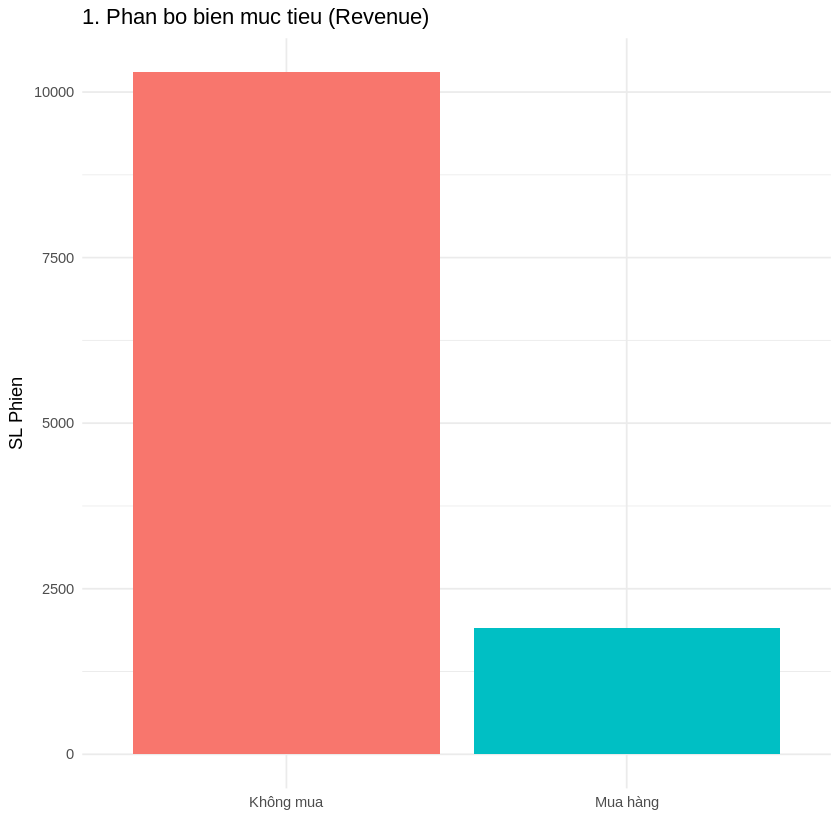

In [386]:
p1 <- ggplot(df, aes(x = Revenue, fill = as.factor(Revenue))) +
  geom_bar(show.legend = FALSE) +
  scale_x_discrete(labels=c("Không mua", "Mua hàng")) +
  labs(title = "1. Phan bo bien muc tieu (Revenue)",
       x = "", y = "SL Phien") +
  theme_minimal()
print(p1)

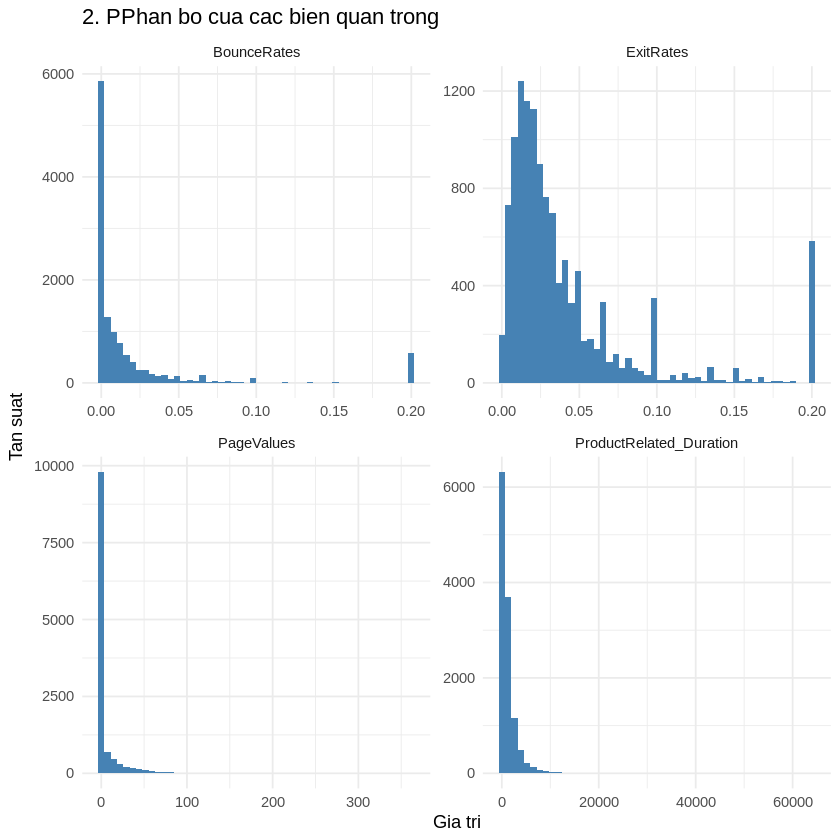

In [387]:
numerical_cols <- c("ProductRelated_Duration", "BounceRates", "ExitRates", "PageValues")
df %>%
  select(all_of(numerical_cols)) %>%
  pivot_longer(everything(), names_to = "variable", values_to = "value") %>%
  ggplot(aes(x = value)) +
    geom_histogram(bins = 50, fill = "steelblue") +
    facet_wrap(~variable, scales = "free") +
    labs(title = "2. PPhan bo cua cac bien quan trong", x="Gia tri", y="Tan suat") +
    theme_minimal()

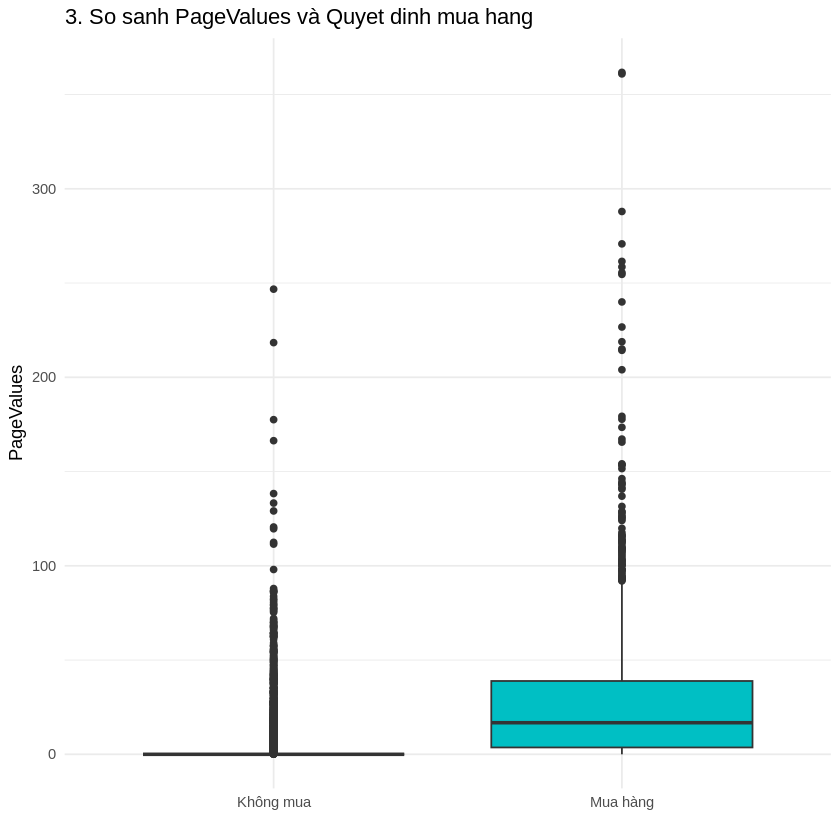

In [388]:
p3 <- ggplot(df, aes(x = Revenue, y = PageValues, fill = as.factor(Revenue))) +
  geom_boxplot(show.legend = FALSE) +
  scale_x_discrete(labels=c("Không mua", "Mua hàng")) +
  labs(title = "3. So sanh PageValues và Quyet dinh mua hang",
       x = "", y = "PageValues") +
  theme_minimal()
print(p3)

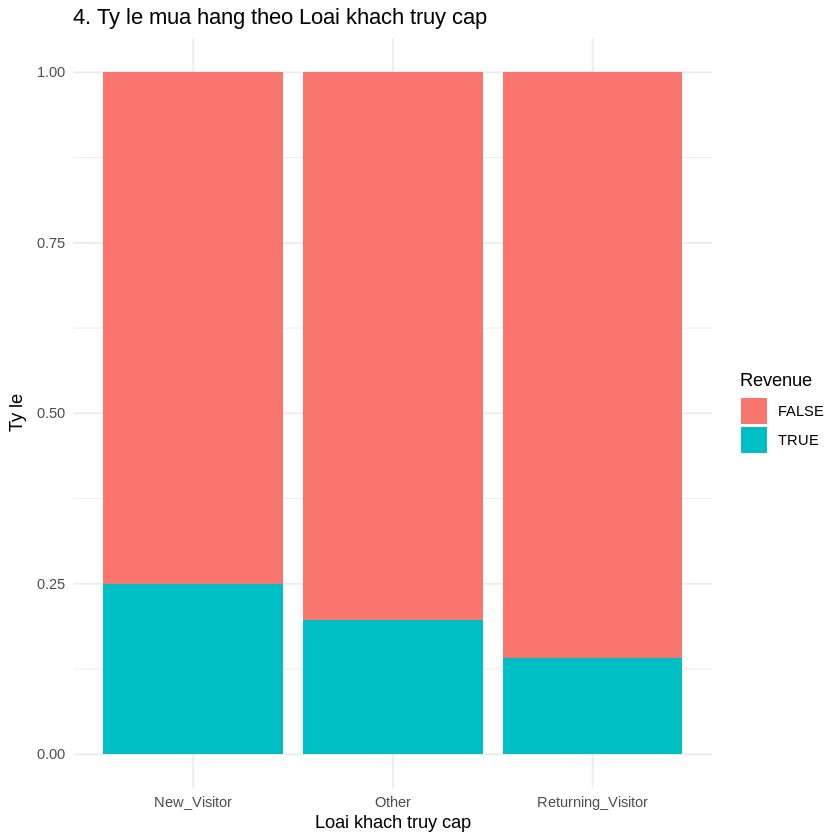

In [389]:
p4 <- ggplot(df, aes(x = VisitorType, fill = Revenue)) +
    geom_bar(position = "fill") +
    labs(title = "4. Ty le mua hang theo Loai khach truy cap",
         x = "Loai khach truy cap", y = "Ty le") +
    theme_minimal()
print(p4)

--- Tính toán Ma trận Tương quan Cramer's V ---
Tính toán Cramer's V xong.

--- Vẽ biểu đồ Corrplot ---


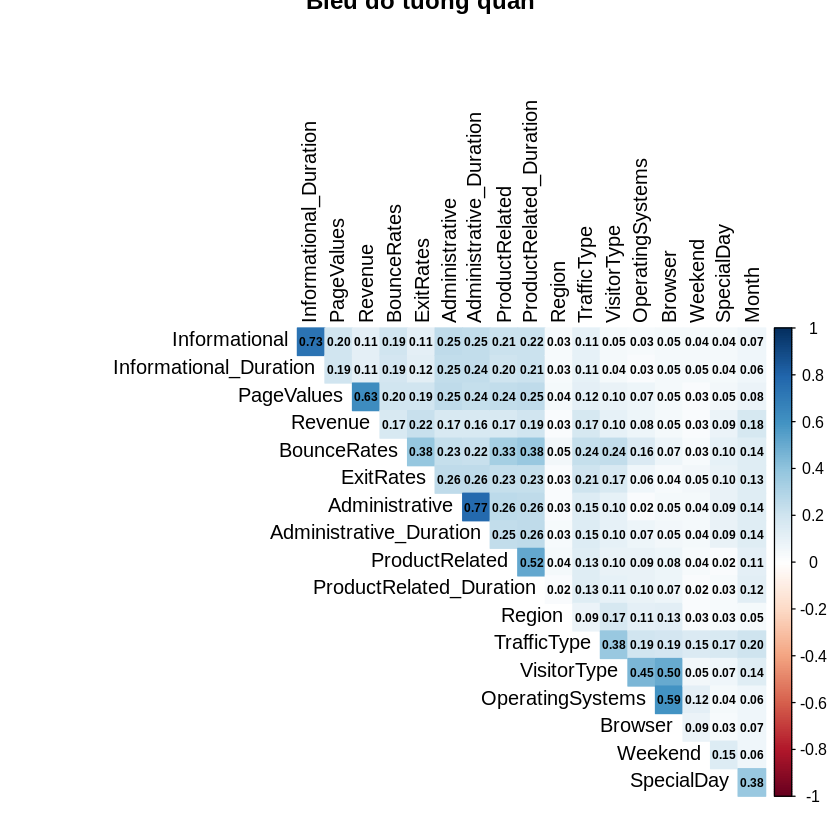

In [390]:
library(corrplot)
library(DescTools)

cat("--- Tính toán Ma trận Tương quan Cramer's V ---\n")
factor_variables <- names(df_final)[sapply(df_final, is.factor)]
num_vars <- length(factor_variables)
cramer_matrix <- matrix(NA, nrow = num_vars, ncol = num_vars,
                        dimnames = list(factor_variables, factor_variables))
for (i in 1:num_vars) {
  for (j in i:num_vars) {
    var1_name <- factor_variables[i]
    var2_name <- factor_variables[j]
    if (i == j) {
      cramer_matrix[i, j] <- 1.0
      next
    }

    tryCatch({
      contingency_table <- table(df_final[[var1_name]], df_final[[var2_name]])
      if (all(dim(contingency_table) > 1)) {
        cramer_val <- CramerV(contingency_table)
        cramer_matrix[i, j] <- cramer_val
        cramer_matrix[j, i] <- cramer_val
      } else {
         cramer_matrix[i, j] <- 0
         cramer_matrix[j, i] <- 0
      }
    }, error = function(e) {
      cat("  Lỗi khi tính Cramer's V cho cặp:", var1_name, "-", var2_name, "-", e$message, "\n")
      cramer_matrix[i, j] <- NA
      cramer_matrix[j, i] <- NA
    })
  }
}

cat("Tính toán Cramer's V xong.\n\n")
cramer_matrix[is.na(cramer_matrix)] <- 0

# --- VẼ BIỂU ĐỒ CORRPLOT ---
cat("--- Vẽ biểu đồ Corrplot ---\n")
corrplot(cramer_matrix,
         method = "color",
         type = "upper",
         order = "hclust",
         tl.col = "black",
         addCoef.col = "black",
         number.cex = 0.6,
         diag = FALSE,
         main = "Bieu do tuong quan"
         )

## 4. Xây Dựng Và Huấn Luyện Mô Hình

### 4.1 Mô hình Hill Climb

In [391]:
cat("Các level của 'Administrative' TRƯỚC khi dọn dẹp:\n")
print(levels(df_final$Administrative))
cat("\nBảng tần suất của 'Administrative':\n")
print(table(df_final$Administrative))

for (col_name in names(df_final)) {
  if (is.factor(df_final[[col_name]])) {
    df_final[[col_name]] <- factor(df_final[[col_name]])
  }
}

cat("\n-------------------------------------------------\n")
cat("Đã dọn dẹp xong các biến factor.\n")
cat("Các level của 'Administrative' SAU khi dọn dẹp:\n")
print(levels(df_final$Administrative))
cat("\nBây giờ dữ liệu đã hoàn toàn sẵn sàng.\n")

Các level của 'Administrative' TRƯỚC khi dọn dẹp:
[1] "Zero" "Low"  "High"

Bảng tần suất của 'Administrative':

Zero  Low High 
5643 3383 3179 

-------------------------------------------------
Đã dọn dẹp xong các biến factor.
Các level của 'Administrative' SAU khi dọn dẹp:
[1] "Zero" "Low"  "High"

Bây giờ dữ liệu đã hoàn toàn sẵn sàng.


Chuyển đổi dữ liệu sang định dạng data.frame cơ bản...
Định dạng dữ liệu sau khi chuyển đổi: data.frame 

Bắt đầu học cấu trúc mạng...
Đang học tham số cho mạng...

Bảng xác suất có điều kiện (CPT) của biến 'Revenue':

  Parameters of node Revenue (multinomial distribution)

Conditional probability table:
 
, , Month = Aug

       PageValues
Revenue       Zero        Low       High
  FALSE 0.94687500 0.64406780 0.29629630
  TRUE  0.05312500 0.35593220 0.70370370

, , Month = Dec

       PageValues
Revenue       Zero        Low       High
  FALSE 0.97073884 0.66187050 0.35500000
  TRUE  0.02926116 0.33812950 0.64500000

, , Month = Feb

       PageValues
Revenue       Zero        Low       High
  FALSE 1.00000000 0.00000000 0.60000000
  TRUE  0.00000000 1.00000000 0.40000000

, , Month = Jul

       PageValues
Revenue       Zero        Low       High
  FALSE 0.94224924 0.65573770 0.38095238
  TRUE  0.05775076 0.34426230 0.61904762

, , Month = June

       PageValues
Revenue       Zero 

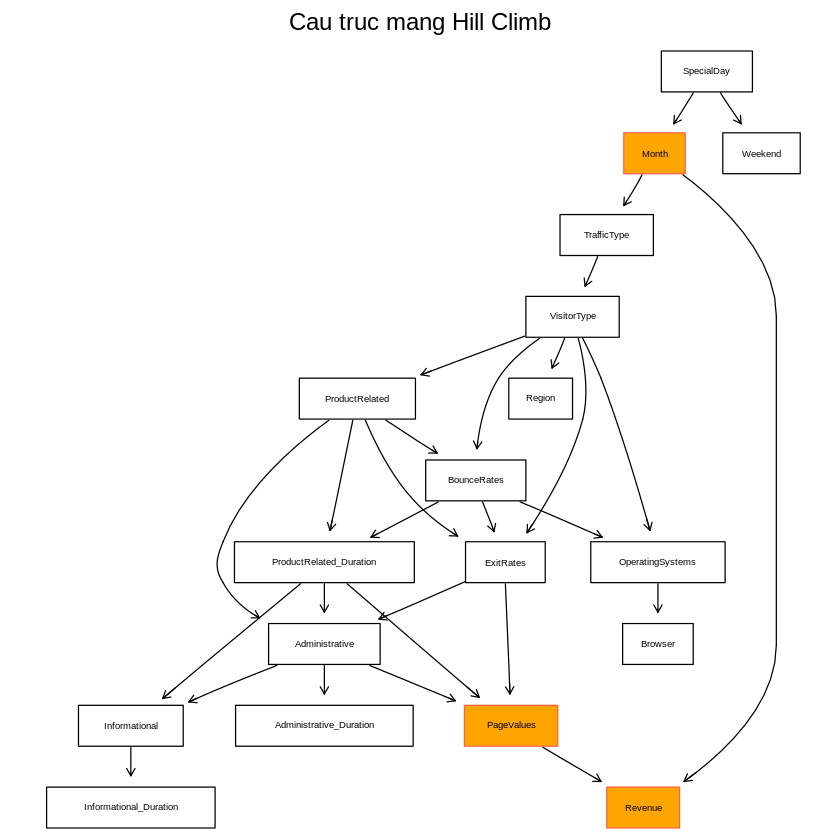

In [392]:
cat("Chuyển đổi dữ liệu sang định dạng data.frame cơ bản...\n")
df_final <- as.data.frame(df_final)
cat("Định dạng dữ liệu sau khi chuyển đổi:", class(df_final), "\n\n")

cat("Bắt đầu học cấu trúc mạng...\n")
bn_structure_final <- hc(df_final)

cat("Đang học tham số cho mạng...\n")
bn_fitted_final <- bn.fit(bn_structure_final, data = df_final)

cat("\nBảng xác suất có điều kiện (CPT) của biến 'Revenue':\n")
print(bn_fitted_final$Revenue)

cat("\nĐang vẽ đồ thị mạng Bayes...\n")
highlight_options <- list(
  nodes = c("Revenue", mb(bn_structure_final, "Revenue")),
  col = "tomato",
  fill = "orange"
)

graphviz.plot(
  bn_structure_final,
  highlight = highlight_options,
  main = "Cau truc mang Hill Climb"
)

In [393]:
if(!require(caTools)) install.packages("caTools")
library(caTools)

set.seed(42)
split <- sample.split(df_final$Revenue, SplitRatio = 0.9)

# Tạo tập huấn luyện (90%)
train_set <- subset(df_final, split == TRUE)

# Tạo tập kiểm tra (10%)
test_set <- subset(df_final, split == FALSE)

cat("Kích thước tập dữ liệu gốc:", dim(df_final), "\n")
cat("Kích thước tập huấn luyện (90%):", dim(train_set), "\n")
cat("Kích thước tập kiểm tra (10%):", dim(test_set), "\n\n")

# Kiểm tra tỷ lệ biến 'Revenue' trong mỗi tập
cat("Tỷ lệ 'Revenue' trong tập dữ liệu gốc:\n")
print(prop.table(table(df_final$Revenue)))
cat("\nTỷ lệ 'Revenue' trong tập huấn luyện:\n")
print(prop.table(table(train_set$Revenue)))
cat("\nTỷ lệ 'Revenue' trong tập kiểm tra:\n")
print(prop.table(table(test_set$Revenue)))

Kích thước tập dữ liệu gốc: 12205 18 
Kích thước tập huấn luyện (90%): 10984 18 
Kích thước tập kiểm tra (10%): 1221 18 

Tỷ lệ 'Revenue' trong tập dữ liệu gốc:

    FALSE      TRUE 
0.8436706 0.1563294 

Tỷ lệ 'Revenue' trong tập huấn luyện:

    FALSE      TRUE 
0.8436817 0.1563183 

Tỷ lệ 'Revenue' trong tập kiểm tra:

    FALSE      TRUE 
0.8435708 0.1564292 


In [394]:
cat("Bắt đầu huấn luyện mô hình trên tập train (90%)...\n")

# Học cấu trúc và tham số
bn_structure_train <- hc(train_set)
bn_fitted_train <- bn.fit(bn_structure_train, data = train_set, method = "bayes", iss = 10)

cat("Huấn luyện xong!\n\n")
cat("Bắt đầu dự đoán trên tập test (10%)...\n")
test_features <- test_set
test_features$Revenue <- NULL

# Thực hiện dự đoán
predictions <- predict(bn_fitted_train, node = "Revenue", data = test_features, method = "bayes-lw")

cat("Dự đoán xong!\n\n")
cat("Kết quả đánh giá mô hình:\n")

# Tạo ma trận nhầm lẫn (Confusion Matrix)
# So sánh giá trị thực tế (test_set$Revenue) và giá trị dự đoán (predictions)
conf_matrix <- table(Predicted = predictions, Actual = test_set$Revenue)

print("Ma trận nhầm lẫn (Confusion Matrix):")
print(conf_matrix)

# Tính toán độ chính xác (Accuracy)
accuracy <- sum(diag(conf_matrix)) / sum(conf_matrix)
cm_hc <- conf_matrix
cat("\nĐộ chính xác (Accuracy) trên tập test:", sprintf("%.2f%%", accuracy * 100), "\n")

Bắt đầu huấn luyện mô hình trên tập train (90%)...
Huấn luyện xong!

Bắt đầu dự đoán trên tập test (10%)...
Dự đoán xong!

Kết quả đánh giá mô hình:
[1] "Ma trận nhầm lẫn (Confusion Matrix):"
         Actual
Predicted FALSE TRUE
    FALSE   969   77
    TRUE     61  114

Độ chính xác (Accuracy) trên tập test: 88.70% 


In [395]:
# Thiết lập seed
set.seed(123)

cat("Bắt đầu thực hiện 10-fold cross-validation...\n")

# Gọi hàm bn.cv()
cv_results <- bn.cv(df_final,
                    bn = "hc",
                    loss = "pred",
                    loss.args = list(target = "Revenue"))

# In kết quả tóm tắt mặc định
print(cv_results)
all_losses <- sapply(cv_results, '[[', 'loss')
expected_loss <- mean(all_losses, na.rm = TRUE)

Bắt đầu thực hiện 10-fold cross-validation...


Warning message in check.data(x, allow.missing = TRUE):
“variable TrafficType in the data has levels that are not observed in the data.”
Warning message in check.data(x, allow.missing = TRUE):
“variable Browser in the data has levels that are not observed in the data.”
Warning message in check.data(x, allow.missing = TRUE):
“variable TrafficType in the data has levels that are not observed in the data.”



  k-fold cross-validation for Bayesian networks

  target learning algorithm:             Hill-Climbing 
  number of folds:                       10 
  loss function:                         Classification Error 
  training node:                         Revenue 
  expected loss:                         0.103081 



###4.2 Mô hình Tabu

Chuyển đổi dữ liệu sang định dạng data.frame cơ bản...
Định dạng dữ liệu sau khi chuyển đổi: data.frame 

Bắt đầu học cấu trúc mạng...
Đang học tham số cho mạng...

Bảng xác suất có điều kiện (CPT) của biến 'Revenue':

  Parameters of node Revenue (multinomial distribution)

Conditional probability table:
 
, , Month = Aug

       PageValues
Revenue         Zero          Low         High
  FALSE 9.468285e-01 6.439864e-01 2.964220e-01
  TRUE  5.317154e-02 3.560136e-01 7.035780e-01

, , Month = Dec

       PageValues
Revenue         Zero          Low         High
  FALSE 9.707274e-01 6.618317e-01 3.550242e-01
  TRUE  2.927263e-02 3.381683e-01 6.449758e-01

, , Month = Feb

       PageValues
Revenue         Zero          Low         High
  FALSE 9.999048e-01 1.612903e-02 5.993377e-01
  TRUE  9.521996e-05 9.838710e-01 4.006623e-01

, , Month = Jul

       PageValues
Revenue         Zero          Low         High
  FALSE 9.422044e-01 6.556526e-01 3.810468e-01
  TRUE  5.779556e-02 3.443474e-

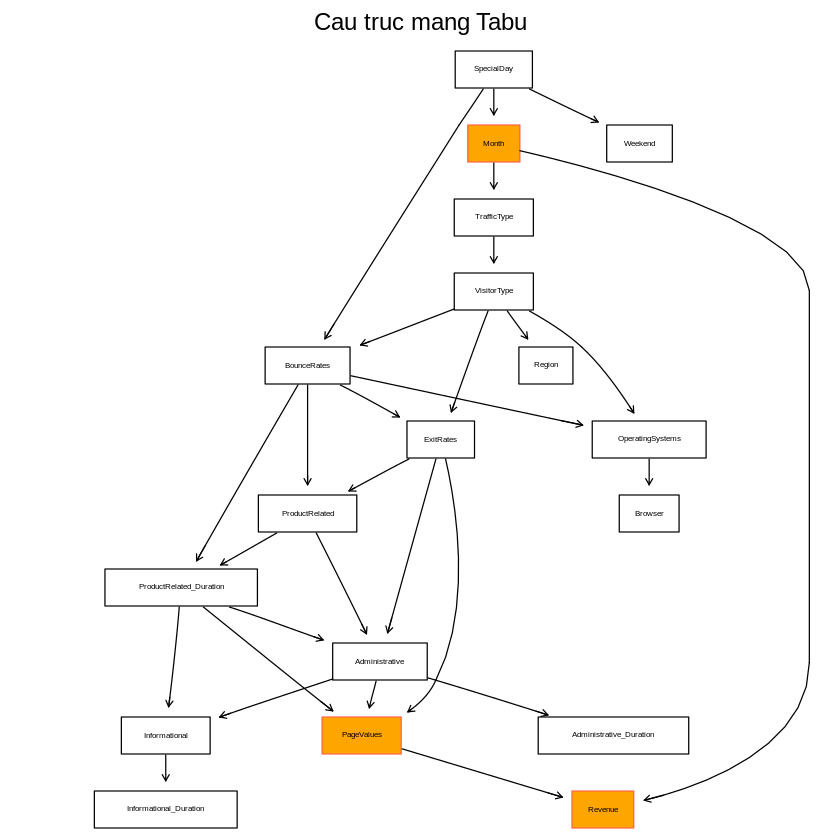

In [396]:
cat("Chuyển đổi dữ liệu sang định dạng data.frame cơ bản...\n")
df_final <- as.data.frame(df_final)
cat("Định dạng dữ liệu sau khi chuyển đổi:", class(df_final), "\n\n")

# 1. Học cấu trúc mạng từ dữ liệu đã được chuyển đổi định dạng
cat("Bắt đầu học cấu trúc mạng...\n")
bn_structure_final <- tabu(df_final)

# 2. Học tham số
cat("Đang học tham số cho mạng...\n")
bn_fitted_final <- bn.fit(bn_structure_final, data = df_final, method = "bayes")

# 3. In ra CPT của 'Revenue'
cat("\nBảng xác suất có điều kiện (CPT) của biến 'Revenue':\n")
print(bn_fitted_final$Revenue)

# 4. Trực quan hóa cấu trúc mạng
cat("\nĐang vẽ đồ thị mạng Bayes...\n")
highlight_options <- list(
  nodes = c("Revenue", mb(bn_structure_final, "Revenue")),
  col = "tomato",
  fill = "orange"
)

graphviz.plot(
  bn_structure_final,
  highlight = highlight_options,
  main = "Cau truc mang Tabu"
)

In [397]:
cat("Bắt đầu huấn luyện mô hình trên tập train (90%)...\n")

# Học cấu trúc và tham số
bn_structure_train2 <- tabu(train_set)
bn_fitted_train <- bn.fit(bn_structure_train2, data = train_set, method = "mle")

cat("Huấn luyện xong!\n\n")
cat("Bắt đầu dự đoán trên tập test (10%)...\n")
test_features <- test_set
test_features$Revenue <- NULL
predictions <- predict(bn_fitted_train, node = "Revenue", data = test_features, method = "bayes-lw")

cat("Dự đoán xong!\n\n")
cat("Kết quả đánh giá mô hình:\n")

conf_matrix <- table(Predicted = predictions, Actual = test_set$Revenue)

print("Ma trận nhầm lẫn (Confusion Matrix):")
print(conf_matrix)

# Tính toán độ chính xác (Accuracy)
accuracy <- sum(diag(conf_matrix)) / sum(conf_matrix)
cm_tabu <- conf_matrix
cat("\nĐộ chính xác (Accuracy) trên tập test:", sprintf("%.2f%%", accuracy * 100), "\n")

Bắt đầu huấn luyện mô hình trên tập train (90%)...
Huấn luyện xong!

Bắt đầu dự đoán trên tập test (10%)...
Dự đoán xong!

Kết quả đánh giá mô hình:
[1] "Ma trận nhầm lẫn (Confusion Matrix):"
         Actual
Predicted FALSE TRUE
    FALSE   963   77
    TRUE     61  114

Độ chính xác (Accuracy) trên tập test: 88.64% 


In [398]:
cat("Thực hiện 10-fold cross-validation với Tabu Search...\\n")
cv_results <- bn.cv(df_final,
                    bn = "tabu",
                    loss = "pred",
                    loss.args = list(target = "Revenue"))
print(cv_results)

Thực hiện 10-fold cross-validation với Tabu Search...\n

Warning message in check.data(x, allow.missing = TRUE):
“variable Browser in the data has levels that are not observed in the data.”
Warning message in check.data(x, allow.missing = TRUE):
“variable TrafficType in the data has levels that are not observed in the data.”
Warning message in check.data(x, allow.missing = TRUE):
“variable TrafficType in the data has levels that are not observed in the data.”



  k-fold cross-validation for Bayesian networks

  target learning algorithm:             Tabu Search 
  number of folds:                       10 
  loss function:                         Classification Error 
  training node:                         Revenue 
  expected loss:                         0.1029171 



In [399]:
library(DescTools)

# Loại bỏ cột Revenue khỏi danh sách các biến độc lập
predictor_vars <- setdiff(names(df_final), "Revenue")
correlations <- numeric(length(predictor_vars))
names(correlations) <- predictor_vars

cat("Đang tính toán Cramer's V cho Revenue với các biến khác...\n")
for (var in predictor_vars) {
  # Tính toán bảng contingency
  contingency_table <- table(df_final[[var]], df_final$Revenue)
  # Tính Cramer's V và lưu trữ
  tryCatch({
    cramers_v <- CramerV(contingency_table)
    correlations[var] <- cramers_v
  }, error = function(e) {
    cat("  Lỗi khi tính Cramer's V cho biến:", var, "-", e$message, "\n")
    correlations[var] <- NA # Gán NA nếu có lỗi
  })
}

# Sắp xếp các biến theo Cramer's V giảm dần
correlations <- correlations[!is.na(correlations)] # Loại bỏ NA nếu có
sorted_correlations <- sort(correlations, decreasing = TRUE)

cat("\\nCác biến được sắp xếp theo Cramer's V (cao nhất đến thấp nhất):\n")
print(sorted_correlations)

# Xác định top 3 cao nhất và thấp nhất
top3_high_corr_vars <- names(sorted_correlations)[1:3]
top3_low_corr_vars <- names(sorted_correlations)[(length(sorted_correlations)-2):length(sorted_correlations)]

cat("\\nTop 3 biến có Cramer's V cao nhất với Revenue:", paste(top3_high_corr_vars, collapse=", "), "\n")
cat("Top 3 biến có Cramer's V thấp nhất với Revenue:", paste(top3_low_corr_vars, collapse=", "), "\n")

Đang tính toán Cramer's V cho Revenue với các biến khác...
\nCác biến được sắp xếp theo Cramer's V (cao nhất đến thấp nhất):
             PageValues               ExitRates ProductRelated_Duration 
             0.62806150              0.22255821              0.19214989 
                  Month             TrafficType          Administrative 
             0.17558466              0.17155931              0.16926913 
            BounceRates          ProductRelated Administrative_Duration 
             0.16871359              0.16531718              0.16136339 
          Informational  Informational_Duration             VisitorType 
             0.11301248              0.11108937              0.10347016 
             SpecialDay        OperatingSystems                 Browser 
             0.08887866              0.07842673              0.04884490 
                 Region                 Weekend 
             0.02816140              0.02772874 
\nTop 3 biến có Cramer's V cao nhất với Revenue

### 4.3 Cấu trúc mạng thủ công Naive Bayes (Top 7)



--- 4a. Xác định Top 7 biến cha cho Revenue ---
Top 7 biến làm cha cho Revenue: PageValues, ExitRates, ProductRelated_Duration, Month, TrafficType, Administrative, BounceRates 

--- 4b. Xác định Cấu trúc Mạng (Selective Naive Bayes) ---
Chuỗi mô tả mô hình: [PageValues][ExitRates][ProductRelated_Duration][Month][TrafficType][Administrative][BounceRates][Administrative_Duration][Informational][Informational_Duration][ProductRelated][SpecialDay][OperatingSystems][Browser][Region][VisitorType][Weekend][Revenue|PageValues:ExitRates:ProductRelated_Duration:Month:TrafficType:Administrative:BounceRates] 
Cấu trúc mạng Selective Naive Bayes đã được xác định.

--- 4c. Huấn luyện Mô hình (Selective Naive Bayes) ---
Bắt đầu huấn luyện (học tham số) trên tập train...
Huấn luyện xong!

--- 4d. Vẽ Đồ thị (Selective Naive Bayes) ---
Đang chuẩn bị vẽ đồ thị mạng Bayes...
Đã yêu cầu vẽ đồ thị.

--- 4e. Dự đoán trên Tập Test (Selective Naive Bayes) ---
Bắt đầu dự đoán Revenue trên tập test...
Dự đoán xo

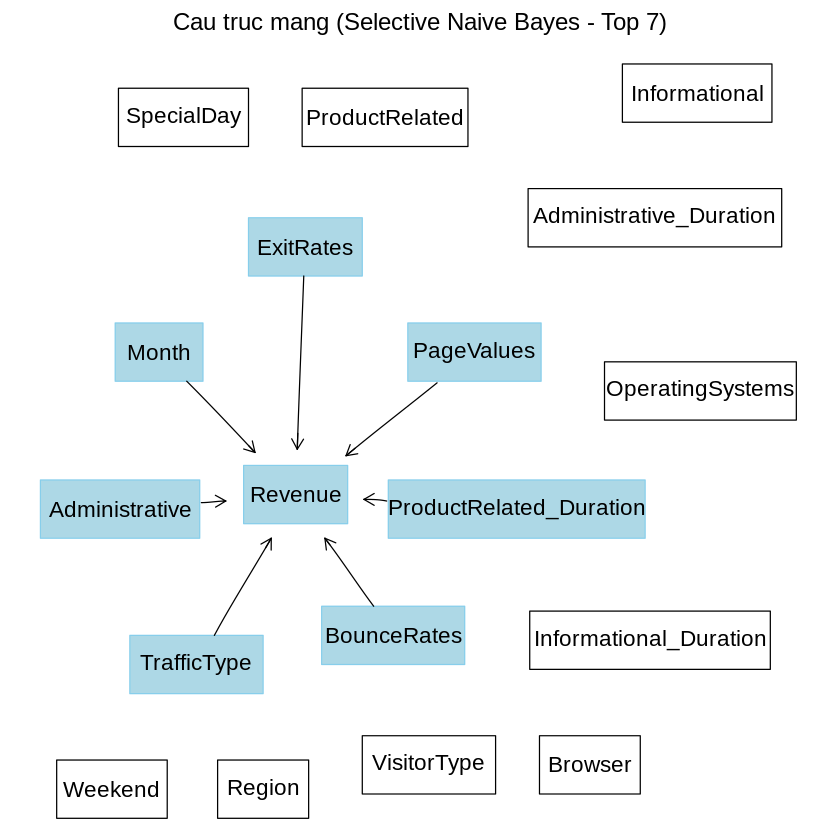

In [400]:
cat("--- 4a. Xác định Top 7 biến cha cho Revenue ---\n")
N_PARENTS <- 7
top_N_vars <- names(sorted_correlations)[1:N_PARENTS]
cat("Top 7 biến làm cha cho Revenue:", paste(top_N_vars, collapse=", "), "\n\n")

cat("--- 4b. Xác định Cấu trúc Mạng (Selective Naive Bayes) ---\n")
all_nodes <- names(df_final)
isolated_nodes <- setdiff(all_nodes, c("Revenue", top_N_vars))
parents_string <- paste0("[", top_N_vars, "]", collapse = "")
isolated_string <- paste0("[", isolated_nodes, "]", collapse = "")
child_string <- paste0("[Revenue|", paste(top_N_vars, collapse = ":"), "]")
model_string_selective_nb <- paste0(parents_string, isolated_string, child_string)
cat("Chuỗi mô tả mô hình:", model_string_selective_nb, "\n")
bn_structure_selective_nb <- empty.graph(all_nodes)
modelstring(bn_structure_selective_nb) <- model_string_selective_nb
cat("Cấu trúc mạng Selective Naive Bayes đã được xác định.\n\n")

cat("--- 4c. Huấn luyện Mô hình (Selective Naive Bayes) ---\n")
cat("Bắt đầu huấn luyện (học tham số) trên tập train...\n")
bn_fitted_selective_nb <- bn.fit(bn_structure_selective_nb,
                                 data = train_set,
                                 method = "bayes",
                                 iss = 10)
cat("Huấn luyện xong!\n\n")

cat("--- 4d. Vẽ Đồ thị (Selective Naive Bayes) ---\n")
library(Rgraphviz)
cat("Đang chuẩn bị vẽ đồ thị mạng Bayes...\n")
options(repr.plot.width = 7, repr.plot.height = 7)

highlight_options_nb_mod <- list(
  nodes = c("Revenue", top_N_vars),
  col = "skyblue",
  fill = "lightblue"
)

graphviz.plot(
  bn_structure_selective_nb,
  main = "Cau truc mang (Selective Naive Bayes - Top 7)",
  highlight = highlight_options_nb_mod,
  layout = "fdp",
  fontsize = 20
)
cat("Đã yêu cầu vẽ đồ thị.\n\n")
options(repr.plot.width = 7, repr.plot.height = 7)
cat("--- 4e. Dự đoán trên Tập Test (Selective Naive Bayes) ---\n")
cat("Bắt đầu dự đoán Revenue trên tập test...\n")
test_features_selective_nb <- test_set
test_features_selective_nb$Revenue <- NULL
predictions_selective_nb <- predict(bn_fitted_selective_nb,
                                    node = "Revenue",
                                    data = test_features_selective_nb,
                                    method = "bayes-lw")
cat("Dự đoán xong!\n\n")

cat("--- 4f. Đánh giá Kết quả (Selective Naive Bayes) ---\n")
conf_matrix_selective_nb <- table(Predicted = predictions_selective_nb, Actual = test_set$Revenue)
print("Ma trận nhầm lẫn (Confusion Matrix):")
print(conf_matrix_selective_nb)

cm_selective_nb <- conf_matrix_selective_nb

if (nrow(cm_selective_nb) == 2 && ncol(cm_selective_nb) == 2 &&
    all(dimnames(cm_selective_nb)[[1]] %in% c("FALSE", "TRUE")) &&
    all(dimnames(cm_selective_nb)[[2]] %in% c("FALSE", "TRUE"))) {

  cm_ordered <- cm_selective_nb[c("FALSE", "TRUE"), c("FALSE", "TRUE")]
  TP <- cm_ordered["TRUE", "TRUE"]
  TN <- cm_ordered["FALSE", "FALSE"]
  FP <- cm_ordered["TRUE", "FALSE"]
  FN <- cm_ordered["FALSE", "TRUE"]

  Accuracy <- (TP + TN) / sum(cm_ordered)
  Precision <- ifelse((TP + FP) == 0, 0, TP / (TP + FP))
  Recall <- ifelse((TP + FN) == 0, 0, TP / (TP + FN))
  Specificity <- ifelse((TN + FP) == 0, 0, TN / (TN + FP))
  F1_Score <- ifelse((Precision + Recall) == 0, 0, 2 * (Precision * Recall) / (Precision + Recall))

  cat("\nĐộ chính xác (Accuracy):", sprintf("%.2f%%", Accuracy * 100), "\n")
  cat("Precision (cho lớp TRUE):", sprintf("%.4f", Precision), "\n")
  cat("Recall (cho lớp TRUE):", sprintf("%.4f", Recall), "\n")
  cat("Specificity (cho lớp FALSE):", sprintf("%.4f", Specificity), "\n")
  cat("F1-Score (cho lớp TRUE):", sprintf("%.4f", F1_Score), "\n")

} else {
  accuracy <- sum(diag(cm_selective_nb)) / sum(cm_selective_nb)
  cat("\nĐộ chính xác (Accuracy):", sprintf("%.2f%%", accuracy * 100), "\n")
  cat("Không thể tính đầy đủ Precision, Recall, F1 (Ma trận không chuẩn 2x2).\n")
}

### 4.4 Câu trúc mạng có while list

In [401]:
# --- 3. TÍNH TOÁN CRAMER'S V VÀ XÁC ĐỊNH TOP 3 ---
predictor_vars <- setdiff(names(df_final), "Revenue")
correlations <- numeric(length(predictor_vars))
names(correlations) <- predictor_vars

cat("Đang tính toán Cramer's V cho Revenue với các biến khác...\n")
for (var in predictor_vars) {
  tryCatch({
    contingency_table <- table(df_final[[var]], df_final$Revenue)
    cramers_v <- CramerV(contingency_table)
    correlations[var] <- cramers_v
  }, error = function(e) {
    cat("  Lỗi khi tính Cramer's V cho biến:", var, "-", e$message, "\n")
    correlations[var] <- NA
  })
}
correlations <- correlations[!is.na(correlations)]
sorted_correlations <- sort(correlations, decreasing = TRUE)

cat("\nCác biến được sắp xếp theo Cramer's V (cao nhất đến thấp nhất):\n")
print(sorted_correlations)

top3_high_corr_vars <- names(sorted_correlations)[1:3]
cat("\nTop 3 biến có Cramer's V cao nhất với Revenue:", paste(top3_high_corr_vars, collapse=", "), "\n")

Đang tính toán Cramer's V cho Revenue với các biến khác...

Các biến được sắp xếp theo Cramer's V (cao nhất đến thấp nhất):
             PageValues               ExitRates ProductRelated_Duration 
             0.62806150              0.22255821              0.19214989 
                  Month             TrafficType          Administrative 
             0.17558466              0.17155931              0.16926913 
            BounceRates          ProductRelated Administrative_Duration 
             0.16871359              0.16531718              0.16136339 
          Informational  Informational_Duration             VisitorType 
             0.11301248              0.11108937              0.10347016 
             SpecialDay        OperatingSystems                 Browser 
             0.08887866              0.07842673              0.04884490 
                 Region                 Weekend 
             0.02816140              0.02772874 

Top 3 biến có Cramer's V cao nhất với Revenue: 

In [402]:
# --- 4. TẠO WHITELIST CHO TOP 3 ---
cat("Tạo whitelist cho top 3 biến có cor cao nhất đến Revenue...\n")
wl_top3_only <- data.frame(from = top3_high_corr_vars,
                           to = rep("Revenue", 3))
print("Whitelist (Top 3 -> Revenue):")
print(wl_top3_only)
cat("\n")

Tạo whitelist cho top 3 biến có cor cao nhất đến Revenue...
[1] "Whitelist (Top 3 -> Revenue):"
                     from      to
1              PageValues Revenue
2               ExitRates Revenue
3 ProductRelated_Duration Revenue



Kích thước tập huấn luyện: 10984 18 
Kích thước tập kiểm tra: 1221 18 
Học cấu trúc mạng (hc) chỉ với whitelist top 3 trên tập train...
Học cấu trúc xong.
Học tham số bằng Bayesian estimation (iss=10)...
Học tham số xong.

Đang chuẩn bị vẽ đồ thị mạng Bayes (Whitelist Top 3)... 


Warning message in graphviz.backend(nodes = nodes, arcs = arcs, highlight = highlight, :
“no node to apply the 'fill' color to, ignoring.”


Đã yêu cầu vẽ đồ thị.

Bắt đầu dự đoán Revenue trên tập test...
Dự đoán xong!

Kết quả đánh giá mô hình (Whitelist Top 3 vào Revenue):
[1] "Ma trận nhầm lẫn (Confusion Matrix):"
         Actual
Predicted FALSE TRUE
    FALSE   989  106
    TRUE     35   85

Độ chính xác (Accuracy): 88.40% 
Precision (cho lớp TRUE): 0.7083 
Recall (Sensitivity, cho lớp TRUE): 0.4450 
Specificity (cho lớp FALSE): 0.9658 
F1-Score (cho lớp TRUE): 0.5466 


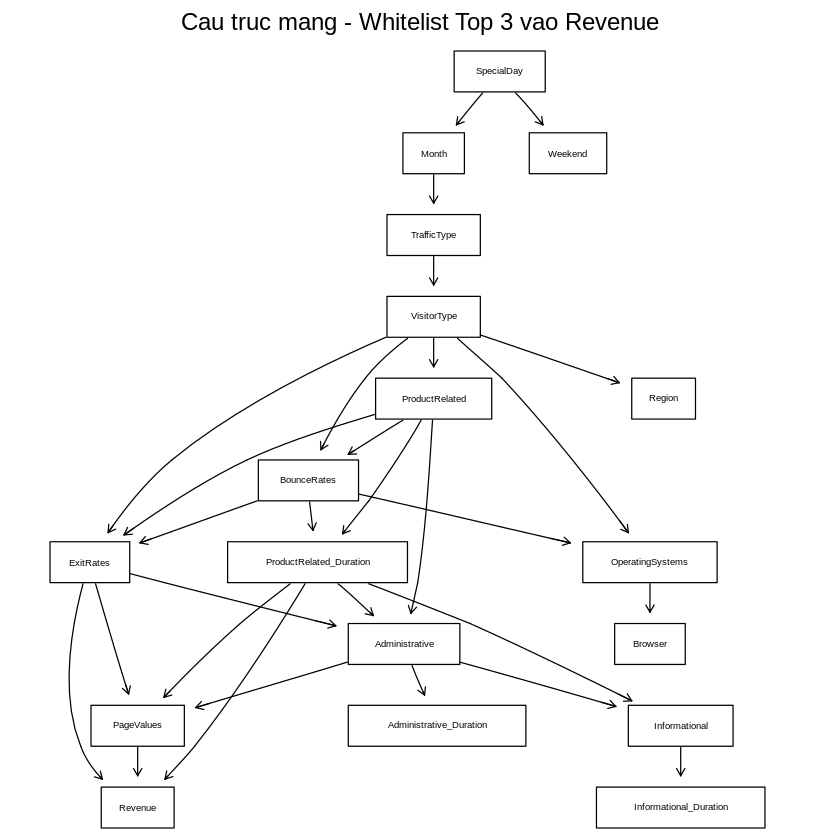

In [403]:
# --- 5. CHIA DỮ LIỆU TRAIN/TEST ---
set.seed(42)
split <- sample.split(df_final$Revenue, SplitRatio = 0.9)
train_set <- subset(df_final, split == TRUE)
test_set <- subset(df_final, split == FALSE)

cat("Kích thước tập huấn luyện:", dim(train_set), "\n")
cat("Kích thước tập kiểm tra:", dim(test_set), "\n")

# --- 6. HỌC CẤU TRÚC VÀ HUẤN LUYỆN MÔ HÌNH CHỈ VỚI WHITELIST ---
cat("Học cấu trúc mạng (hc) chỉ với whitelist top 3 trên tập train...\n")
bn_structure_wl_only <- hc(train_set, whitelist = wl_top3_only)
cat("Học cấu trúc xong.\n")

cat("Học tham số bằng Bayesian estimation (iss=10)...\n")
bn_fitted_wl_only <- bn.fit(bn_structure_wl_only, data = train_set)
cat("Học tham số xong.\n\n")

# --- 7. VẼ ĐỒ THỊ MẠNG BAYES ---
cat("Đang chuẩn bị vẽ đồ thị mạng Bayes (Whitelist Top 3)... \n")
tryCatch({
  plot_title <- "Cau truc mang - Whitelist Top 3 vao Revenue"
  highlight_options_wl <- list(
    col = "skyblue",
    fill = "lightblue"
   )
  graphviz.plot(bn_structure_wl_only, main = plot_title, highlight = highlight_options_wl)
  cat("Đã yêu cầu vẽ đồ thị.\n\n")
}, error = function(e){
  cat("Không thể vẽ đồ thị, có thể do thiếu thư viện hoặc lỗi khác:", e$message, "\n")
})


# --- 8. DỰ ĐOÁN TRÊN TẬP TEST ---
cat("Bắt đầu dự đoán Revenue trên tập test...\n")
test_features_wl_only <- test_set
test_features_wl_only$Revenue <- NULL

predictions_wl_only <- predict(bn_fitted_wl_only,
                               node = "Revenue",
                               data = test_features_wl_only,
                               method = "bayes-lw",
                               prob = FALSE)

cat("Dự đoán xong!\n\n")

# --- 9. ĐÁNH GIÁ KẾT QUẢ ---
cat("Kết quả đánh giá mô hình (Whitelist Top 3 vào Revenue):\n")
conf_matrix_wl_only <- table(Predicted = predictions_wl_only, Actual = test_set$Revenue)

print("Ma trận nhầm lẫn (Confusion Matrix):")
print(conf_matrix_wl_only)
cm_wl <- conf_matrix_wl_only
# (Code tính toán Accuracy, Precision, Recall, F1, Specificity giống như trước)
if (nrow(conf_matrix_wl_only) == 2 && ncol(conf_matrix_wl_only) == 2 &&
    all(dimnames(conf_matrix_wl_only)[[1]] %in% c("FALSE", "TRUE")) &&
    all(dimnames(conf_matrix_wl_only)[[2]] %in% c("FALSE", "TRUE"))) {

    conf_matrix_wl_only <- conf_matrix_wl_only[c("FALSE", "TRUE"), c("FALSE", "TRUE")] # Đảm bảo thứ tự

    TP <- conf_matrix_wl_only["TRUE", "TRUE"]
    TN <- conf_matrix_wl_only["FALSE", "FALSE"]
    FP <- conf_matrix_wl_only["TRUE", "FALSE"]
    FN <- conf_matrix_wl_only["FALSE", "TRUE"]

    Accuracy <- (TP + TN) / sum(conf_matrix_wl_only)
    Precision <- TP / (TP + FP)
    Recall <- TP / (TP + FN) # Sensitivity
    Specificity <- TN / (TN + FP)
    F1_Score <- 2 * (Precision * Recall) / (Precision + Recall)

    cat("\nĐộ chính xác (Accuracy):", sprintf("%.2f%%", Accuracy * 100), "\n")
    cat("Precision (cho lớp TRUE):", ifelse(is.nan(Precision), "N/A", sprintf("%.4f", Precision)), "\n")
    cat("Recall (Sensitivity, cho lớp TRUE):", ifelse(is.nan(Recall), "N/A", sprintf("%.4f", Recall)), "\n")
    cat("Specificity (cho lớp FALSE):", ifelse(is.nan(Specificity), "N/A", sprintf("%.4f", Specificity)), "\n")
    cat("F1-Score (cho lớp TRUE):", ifelse(is.nan(F1_Score), "N/A", sprintf("%.4f", F1_Score)), "\n")

} else {
    accuracy <- sum(diag(conf_matrix_wl_only)) / sum(conf_matrix_wl_only)
    cat("\nĐộ chính xác (Accuracy):", sprintf("%.2f%%", accuracy * 100), "\n")
    cat("Không thể tính đầy đủ Precision, Recall, F1 do ma trận nhầm lẫn không đúng kích thước 2x2 hoặc tên nhãn không chuẩn (FALSE, TRUE).\n")
}

--- Tổng hợp Metrics cho 4 mô hình ---
Bảng tổng kết Metrics:
                  Model  Accuracy Precision    Recall  F1_Score Specificity
          1. Hill Climb 0.8869779 0.6514286 0.5968586 0.6229508   0.9407767
         2. Tabu Search 0.8864198 0.6514286 0.5968586 0.6229508   0.9404297
 3. Revenue Naive Bayes 0.8525799 0.5279188 0.5445026 0.5360825   0.9097087
     4. Whitelist Top 3 0.8839506 0.7083333 0.4450262 0.5466238   0.9658203

--- Vẽ biểu đồ so sánh ---


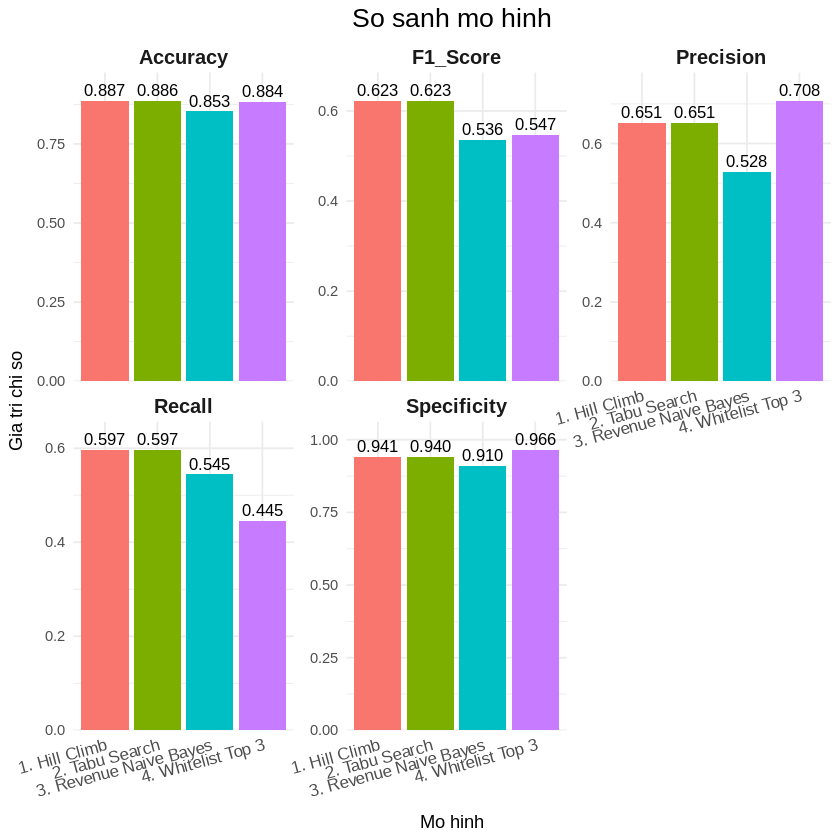

In [404]:
library(ggplot2)
library(tidyr)
calculate_metrics <- function(cm, model_name) {
  Accuracy <- NA
  Precision <- NA
  Recall <- NA
  Specificity <- NA
  F1_Score <- NA
  if (nrow(cm) == 2 && ncol(cm) == 2 &&
      all(dimnames(cm)[[1]] %in% c("FALSE", "TRUE")) &&
      all(dimnames(cm)[[2]] %in% c("FALSE", "TRUE"))) {

    cm_ordered <- cm[c("FALSE", "TRUE"), c("FALSE", "TRUE")]

    TP <- cm_ordered["TRUE", "TRUE"]
    TN <- cm_ordered["FALSE", "FALSE"]
    FP <- cm_ordered["TRUE", "FALSE"]
    FN <- cm_ordered["FALSE", "TRUE"]

    Accuracy <- (TP + TN) / sum(cm_ordered)
    Precision <- ifelse((TP + FP) == 0, 0, TP / (TP + FP))
    Recall <- ifelse((TP + FN) == 0, 0, TP / (TP + FN))
    Specificity <- ifelse((TN + FP) == 0, 0, TN / (TN + FP))
    F1_Score <- ifelse((Precision + Recall) == 0, 0, 2 * (Precision * Recall) / (Precision + Recall))

  } else {
    Accuracy <- sum(diag(cm)) / sum(cm)
    cat("Cảnh báo: Ma trận nhầm lẫn cho", model_name, "không chuẩn 2x2. Chỉ tính Accuracy.\n")
  }

  return(data.frame(Model = model_name,
                    Accuracy = Accuracy,
                    Precision = Precision,
                    Recall = Recall,
                    F1_Score = F1_Score,
                    Specificity = Specificity))
}

cat("--- Tổng hợp Metrics cho 4 mô hình ---\n")

results_hc <- calculate_metrics(cm_hc, "1. Hill Climb")
results_tabu <- calculate_metrics(cm_tabu, "2. Tabu Search")
results_manual <- calculate_metrics(cm_selective_nb, "3. Revenue Naive Bayes")
results_wl <- calculate_metrics(cm_wl, "4. Whitelist Top 3")

all_results <- rbind(results_hc, results_tabu, results_manual, results_wl)

cat("Bảng tổng kết Metrics:\n")
print(all_results, row.names = FALSE)
cat("\n")
results_long <- all_results %>%
  pivot_longer(cols = c(Accuracy, Precision, Recall, F1_Score, Specificity),
               names_to = "Metric",
               values_to = "Value") %>%
  na.omit()

cat("--- Vẽ biểu đồ so sánh ---\n")

comparison_plot <- ggplot(results_long, aes(x = Model, y = Value, fill = Model)) +
  geom_bar(stat = "identity", position = "dodge", show.legend = FALSE) +
  geom_text(aes(label = sprintf("%.3f", Value)),
            position = position_dodge(width = 0.9),
            vjust = -0.4,
            size = 3.5) +
  facet_wrap(~ Metric, scales = "free_y") +
  labs(title = "So sanh mo hinh",
       x = "Mo hinh",
       y = "Gia tri chi so") +
  theme_minimal() +
  theme(
    axis.text.x = element_text(angle = 15, hjust = 1, size = 10),
    plot.title = element_text(hjust = 0.5, size = 16),
    strip.text = element_text(size = 12, face = "bold")
  ) +
  scale_y_continuous(limits = c(0, NA), expand = expansion(mult = c(0, .1)))

print(comparison_plot)